In [1]:
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer 
from tensorflow.keras.models import load_model
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
import  os
import json

In [2]:
model = load_model('best_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               98432     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "dbmdz/bert-base-turkish-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name).to(device)

In [4]:
def feature_extraction(df):
    tokenized = df['review'].apply((lambda x: tokenizer.encode(str(x), add_special_tokens=True)))
    max_len = 0
    for i in tokenized.values:
        if (len(i) > max_len):
            max_len = len(i)
            
    last_hidden_states = []
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = np.where(padded != 0, 1, 0)
    all_hidden_states = []
    batch_size = 8
    for i in range(0, len(padded), batch_size):
        batch_input_ids = torch.tensor(padded[i:i+batch_size]).to(device)
        batch_attention_mask = torch.tensor(attention_mask[i:i+batch_size]).to(device)

        with torch.no_grad():
#             last_hidden_states += list(bert_model(batch_input_ids, attention_mask=batch_attention_mask)[0][0][0].cpu().numpy())
            last_hidden_states += list(bert_model(batch_input_ids, attention_mask=batch_attention_mask)[0][:,0,:].cpu().numpy())
#             list(x[0][0].cpu().numpy())
    return last_hidden_states
    

In [5]:
def get_dataset_path(sub_directory,file_name):
    base_dir = os.getcwd()
    target_dir = os.path.dirname(base_dir)
    file_path = os.path.join(target_dir, sub_directory,file_name)
    return file_path

In [6]:
def read_data(sub_directory,file_name):
    file_path = get_dataset_path(sub_directory,file_name)
    df = pd.read_csv(file_path)
    return df

In [7]:
df = read_data("MachineLearning/Brands","Renault.csv")

In [8]:
df_copy = df.copy()

In [9]:
df.head()

,review,date
0,fransız üretici tarafından paylaşılan görselle...,04.10.2023
1,refale megane e tech austral yeni scenic şimdi...,04.10.2023
2,resime gitmek tıklayın,04.10.2023
3,ben yeni logoyu begenmedim pejo modern sportif...,04.10.2023
4,sürekli model ismi değiştiriyor bunlar karman ...,04.10.2023


In [10]:
mask = df['review'].str.len() < 300 
df = df.loc[mask]

In [11]:
tokens = feature_extraction(df)

In [12]:
len(tokens)

582

In [13]:
len(tokens[0])

768

In [14]:
df.shape[0]

582

In [15]:
df['sentiment'] = 0
sentiments = []
for i in range(0,df.shape[0]):
    token = tokens[i]
#     sentiments.append(np.argmax(model.predict(np.array(token).reshape(1, -1)))-1)
    predict = model.predict(np.array(token).reshape(1, -1))
    sentiment = np.argmax(predict) -1
    score = sentiment * predict[0][np.argmax(predict)] * 100
    sentiments.append(score)


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


In [16]:
sentiments[:10]

[95.09381651878357,
 72.80318140983582,
 96.0391640663147,
 76.88587307929993,
 91.89518690109253,
 88.87683153152466,
 96.56806588172913,
 56.25560283660889,
 72.9698657989502,
 73.1493890285492]

In [17]:
df['sentiment'] = sentiments

In [18]:
df.head()

,review,date,sentiment
1,refale megane e tech austral yeni scenic şimdi...,04.10.2023,95.093817
2,resime gitmek tıklayın,04.10.2023,72.803181
3,ben yeni logoyu begenmedim pejo modern sportif...,04.10.2023,96.039164
4,sürekli model ismi değiştiriyor bunlar karman ...,04.10.2023,76.885873
5,model seneye tarihe karışır tıpkı diğerleri,04.10.2023,91.895187


In [44]:
sentiments[:12]

[85.03409028053284,
 95.0556755065918,
 97.45331406593323,
 76.99923515319824,
 93.1035578250885,
 91.61269664764404,
 89.34441804885864,
 83.22778940200806,
 83.76581072807312,
 96.76560163497925,
 94.36781406402588,
 98.87696504592896]

In [201]:
def analyse(brand):
    df = read_data("MachineLearning/Brands",f'{brand}.csv')
    
    mask = df['review'].str.len() < 300 
    df = df.loc[mask]
    df.head()
    
    tokens = feature_extraction(df)
    
    df['sentiment'] = 0
    
    sentiments = []
    for i in range(0,df.shape[0]):
        token = tokens[i]
        predict = model.predict(np.array(token).reshape(1, -1))
        sentiment = np.argmax(predict) -1
        score = sentiment * predict[0][np.argmax(predict)] * 100
        sentiments.append(score)
    
    dates = np.array(df['date'])
    dates = [datetime.strptime(x, "%d.%m.%Y").strftime("%Y-%m-%d") if "." in x else x for x in dates]
    dates = np.array(dates)
    indices = np.argsort(dates)
    
    dates = dates[indices]
    sentiments =np.array(sentiments)[indices]
    
    days = {}
    j= 1
    for i in range(len(dates)-1):
        if dates[i] == dates[i+1]:
            j += 1
        else:
            days[i] = j
            j = 1
    comment_number =  list(days.values())      
    days = list(days.keys())
    days.insert(0, 0)
    
    scores = []
    for i in range(len(days)-1):
        scores.append(sentiments[days[i]:days[i+1]])
    
    days_scores = {}
    for i in range(len(scores)):
        if len(scores[i]) != 0:
            days_scores[dates[days[i+1]]] = sum(scores[i])/len(scores[i])
        
    days = list(days_scores.keys())
    scores = list(days_scores.values())
    
    days_scores = {
    "date": days,
    "score": scores,
    "comment_number": comment_number
    }

    if not os.path.exists("Scores"):
        os.makedirs("Scores")

    json_file_path = os.path.join("Scores", f'{brand}.json')
    with open(json_file_path, "w") as json_file:
        json.dump(days_scores, json_file)

In [220]:
def sentiment_graphic(brand):
    json_file_path = f'scores/{brand}.json' 
    
    with open(json_file_path, "r") as json_file:
        days_scores = json.load(json_file)
        
    dates = list(days_scores["date"])
    scores = list(days_scores["score"])
    
    plt.figure(figsize=(15,3))
    plt.plot(dates, scores, color='blue', label='Average Sentiment')
    plt.title(f'Analysis of {brand}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()

In [233]:
def comment_number_graphic(brand):
    json_file_path = f'scores/{brand}.json' 
    
    with open(json_file_path, "r") as json_file:
        days_scores = json.load(json_file)
        
    dates = list(days_scores["date"])
    comment_number = list(days_scores["comment_number"])
    
    plt.figure(figsize=(25,13))
    plt.bar(dates,comment_number)
    plt.show()

In [203]:
file_path = get_dataset_path("MachineLearning","Brands")
file_list = os.listdir(file_path)

brands = []

for file in file_list:
     if file.endswith('.csv'):
        brands.append(file[:-4])

In [204]:
for brand in brands:
    analyse(brand)
    print(f'{brand} is completed!')

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step
Alfa Romeo is completed!
1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step
Audi is completed!
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - 0s 14ms/step
Bmw is completed!
1/1 [==============================] - 0s 15ms/step
Chevrolet is completed!
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step
Citroen is completed!
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step
Dacia is completed!
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step
Diğer Markalar is completed!
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step
Fiat is completed!
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 28ms/step
Ford is completed!
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step
Honda is completed!
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Hyundai is completed!
1/1 [==============================] - 0s 24ms/step
Jeep is completed!
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step
Kia is completed!
1/1 [==============================] - 0s 28ms/step
Mazda is completed!
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 20ms/step
Mercedes is completed!
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step
Mitsubishi is completed!
1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - 0s 24ms/step
Nissan is completed!
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 36ms/step
Opel is completed!
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step
Peugeot is completed!
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 24ms/step
Renault is completed!
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step
Seat is completed!
1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 28ms/step
Skoda is completed!
1/1 [==============================] - 0s 28ms/step
Subaru is completed!
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step
Suzuki is completed!
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 28ms/step
Tesla is completed!
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 36ms/step
TOGG is completed!
1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 28ms/step
Toyota is completed!
1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 24ms/step
Volvo is completed!
1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 28ms/step
Vw is completed!


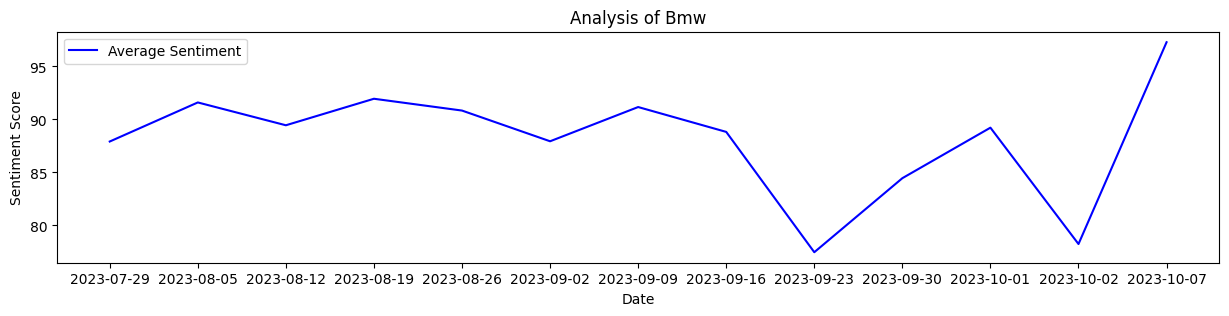

In [222]:
graphic("Bmw")

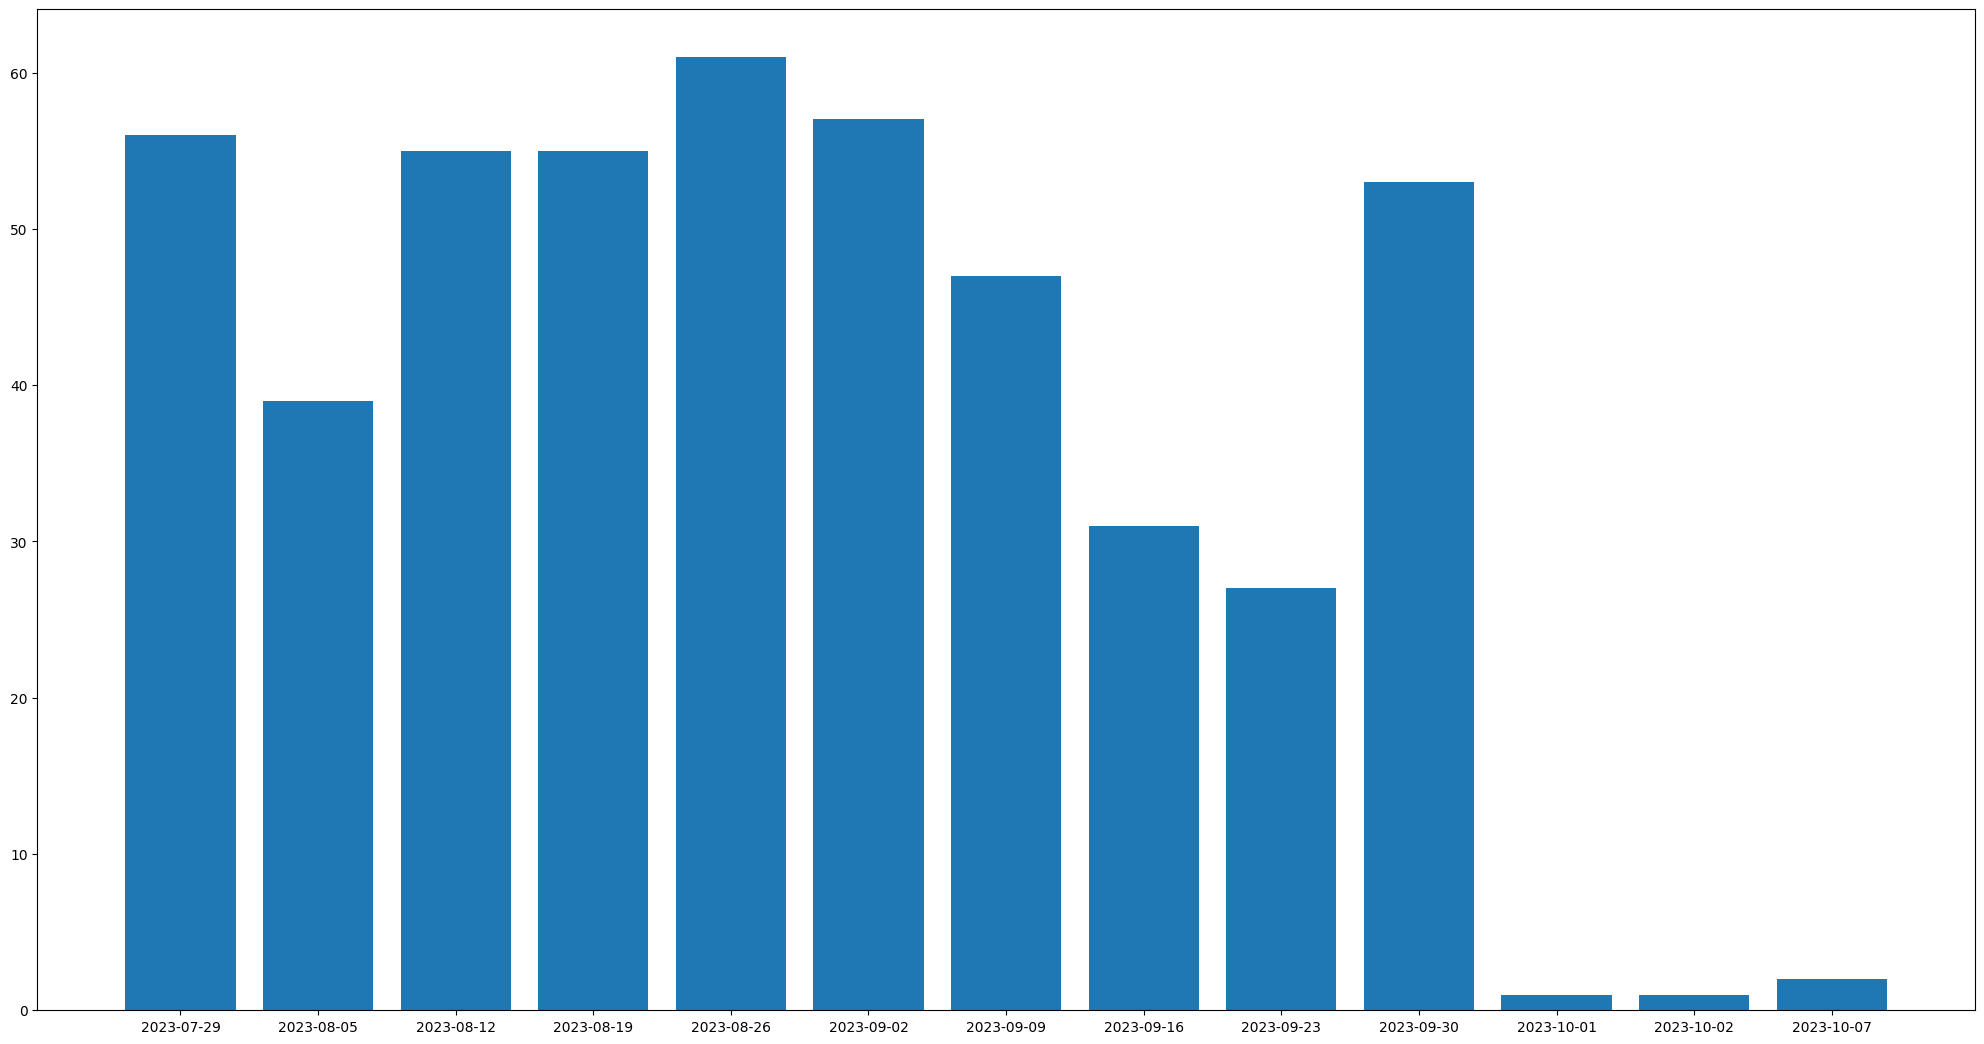

In [234]:
comment_number_graphic("Bmw")

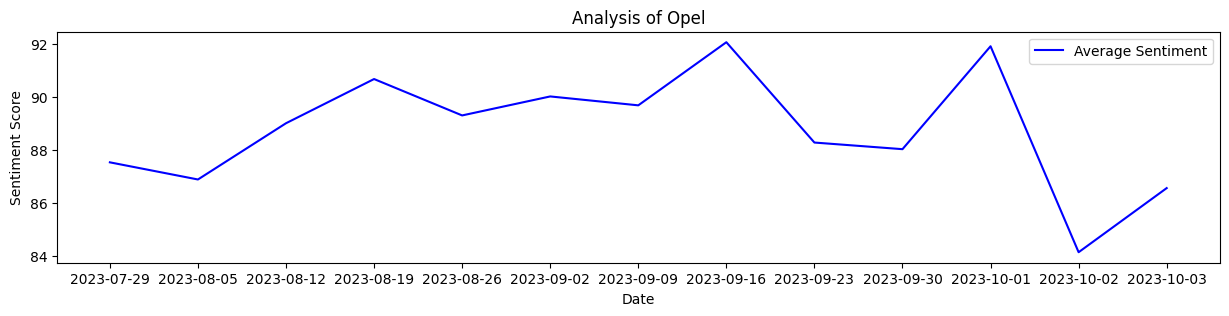

In [221]:
graphic("Opel")

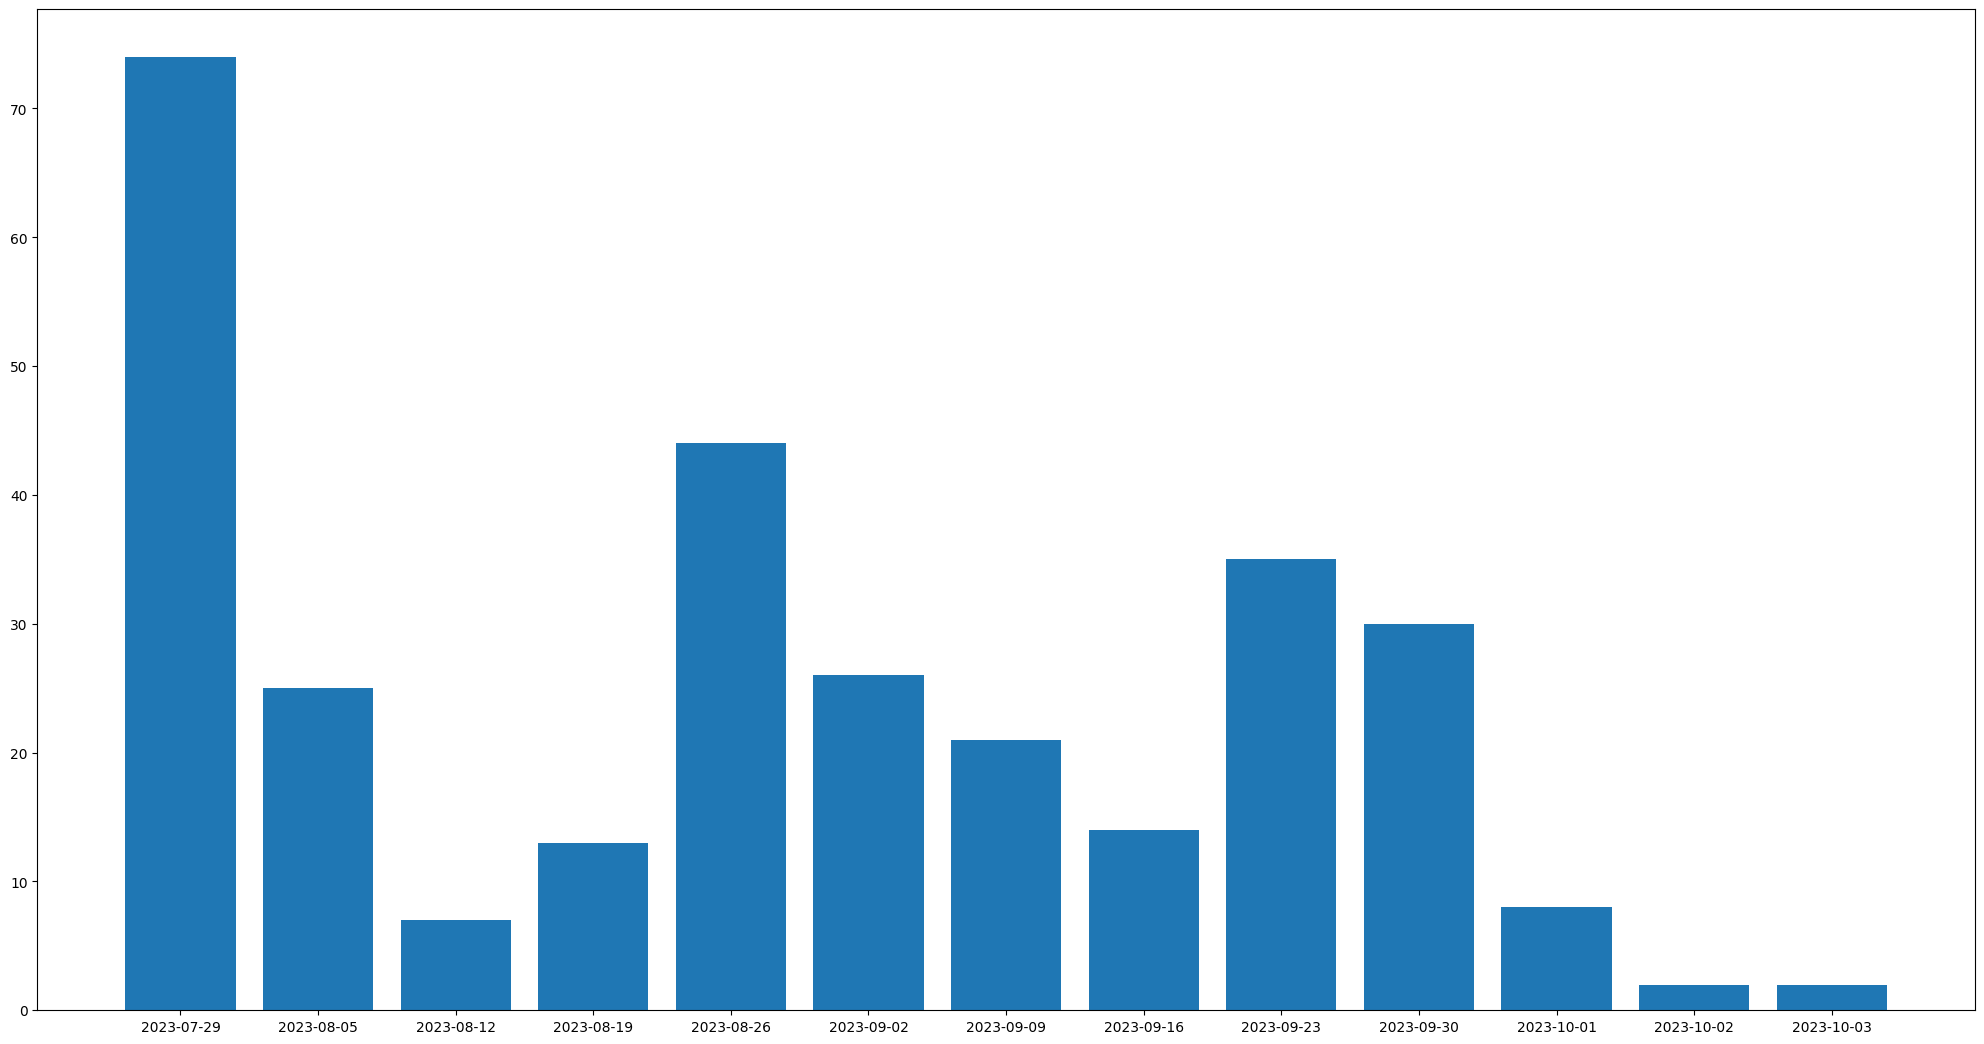

In [235]:
comment_number_graphic("Opel")